# Importing libraries

In [31]:
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

loading faq data

In [32]:
data = pd.read_excel('faq.xlsx')
data1 = pd.read_csv('dialogs.txt', delimiter='\t', header=None, names=['Questions', 'Answers'])


In [33]:
datas = pd.concat([data1, data], ignore_index=True)

In [34]:
# Exploring data
pd.DataFrame(datas).head()

,Questions,Answers
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


# Cleaning data

In [35]:
# Removes duplicates
data = data.drop_duplicates()

In [36]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Questions'])
sequences = tokenizer.texts_to_sequences(data['Questions'])

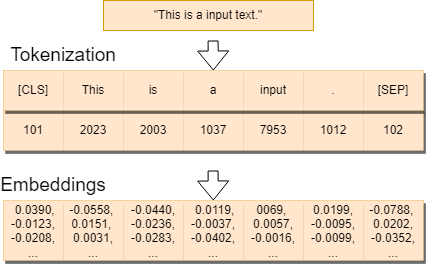

In [37]:
# Converting text to lowercase
data['Questions'] = data['Questions'].str.lower()

Downloading required NLTK libraries

In [38]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:

# stopwords using NLTK
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['Questions'] = data['Questions'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


# Lemmatization using NLTK
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['Questions'] = data['Questions'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

Vectorization

In [40]:
vocab_size = len(tokenizer.word_index) + 1
max_len = 100  # Maximum length of input sequence
input_sequences = pad_sequences(sequences, maxlen=max_len)

Splitting input/output

In [41]:
# Preprocess 'Answers' column
answers = data['Answers'].unique()  # Get unique answers
answer_dict = {answer: index for index, answer in enumerate(answers)}  # Create a dictionary mapping answers to numerical categories
data['Answers'] = data['Answers'].map(answer_dict)  # Map answers to numerical categories in the 'Answers' column

In [42]:
# Splitting into input and output
input_data = input_sequences
output_data = to_categorical(data['Answers'])

# Training/Testing

In [43]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)


In [44]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(LSTM(128))
model.add(Dense(len(answer_dict), activation='softmax'))

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Fitting - Training model

In [46]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 2.3952 - accuracy: 0.1250 - val_loss: 2.4208 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 83ms/step - loss: 2.3783 - accuracy: 0.3750 - val_loss: 2.4438 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 75ms/step - loss: 2.3606 - accuracy: 0.3750 - val_loss: 2.4735 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 72ms/step - loss: 2.3410 - accuracy: 0.3750 - val_loss: 2.5158 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 80ms/step - loss: 2.3176 - accuracy: 0.3750 - val_loss: 2.5829 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 79ms/step - loss: 2.2878 - accuracy: 0.2500 - val_loss: 2.7064 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 76ms/step - loss: 2.2455 - accuracy: 0.2500 - val_loss: 2.9830 - val_accuracy: 0.0000e+00
E

In [47]:
model.save("chatbot.h5")

In [48]:
#load model
model = load_model("chatbot.h5")

In [53]:
question = "haha"
new_sequences = tokenizer.texts_to_sequences([question])
new_input_sequences = pad_sequences(new_sequences, maxlen=max_len)
predictions = model.predict(new_input_sequences)
predicted_indices = np.argmax(predictions, axis=1)
predicted_answers = [answers[index] for index in predicted_indices]

1/1 [==============================] - 0s 49ms/step


In [54]:
print(f"Question: {question}")
print(f"Predicted Answer: {predicted_answers[0]}")

Question: haha
Predicted Answer: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.


In [55]:
while True:
    # Get user input
    question = input("User: ")
    
    # Preprocess user input1
    new_sequences = tokenizer.texts_to_sequences([question])
    new_input_sequences = pad_sequences(new_sequences, maxlen=max_len)
    
    # Generate prediction
    predictions = model.predict(new_input_sequences)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_answers = [answers[index] for index in predicted_indices]

    # Output bot's response
    print("Bot:", predicted_answers[0])
    
    # Check for conversation termination
    if question.lower() == "exit":
        break

1/1 [==============================] - 0s 30ms/step
Bot: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.
1/1 [==============================] - 0s 27ms/step
Bot: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.
1/1 [==============================] - 0s 26ms/step
Bot: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.
1/1 [==============================] - 0s 29ms/step
Bot: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.
1/1 [==============================] - 0s 27ms/step
Bot: Yes, you can cancel your order within 24 hours of placing it. Please contact our customer support team with your order details for assistance.
